In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

sns.set()
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
DATA_PATH = Path("../data/age/")
FIGS_PATH = Path("figures/eda-age/")

In [4]:
CAT_FEATURES = ["small_group"]

In [5]:
%%time

df_train = pd.read_csv(DATA_PATH / "transactions_train.csv", header=0)
df_train

CPU times: user 6.51 s, sys: 1.05 s, total: 7.57 s
Wall time: 7.56 s


,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017
2,33172,8,11,13.887
3,33172,9,11,15.983
4,33172,10,11,21.341
...,...,...,...,...
26450572,43300,727,25,7.602
26450573,43300,727,15,3.709
26450574,43300,727,1,6.448
26450575,43300,727,11,24.669


In [6]:
%%time

df_test = pd.read_csv(DATA_PATH / "transactions_test.csv", header=0)
df_test

CPU times: user 4.35 s, sys: 681 ms, total: 5.03 s
Wall time: 5.03 s


,client_id,trans_date,small_group,amount_rur
0,46445,3,0,19.555
1,46445,3,1,27.774
2,46445,4,0,18.114
3,46445,4,1,22.183
4,46445,5,2,45.795
...,...,...,...,...
17667323,14864,727,1,21.824
17667324,14864,728,36,84.900
17667325,14864,728,3,2.748
17667326,14864,728,1,47.369


In [22]:
set(df_train.client_id).intersection(set(df_test.client_id))

set()

In [7]:
%%time

target_train = pd.read_csv(DATA_PATH / "train_target.csv")
target_train

CPU times: user 14.9 ms, sys: 5.64 ms, total: 20.6 ms
Wall time: 18 ms


,client_id,bins
0,24662,2
1,1046,0
2,34089,2
3,34848,1
4,47076,3
...,...,...
29995,14303,1
29996,22301,2
29997,25731,0
29998,16820,3


In [27]:
df_train.isna().any().any()

False

In [28]:
df_test.isna().any().any()

False

In [9]:
lens = df_train.groupby("client_id").size()
lens

client_id
4         720
6         730
7         773
10        706
11        812
         ... 
49993     901
49995     969
49996    1138
49997     715
49998     782
Length: 30000, dtype: int64

In [10]:
lens.value_counts().sort_index()

700     120
701      92
702     119
703     108
704     100
       ... 
1146     36
1147     31
1148     42
1149     37
1150     45
Name: count, Length: 451, dtype: int64

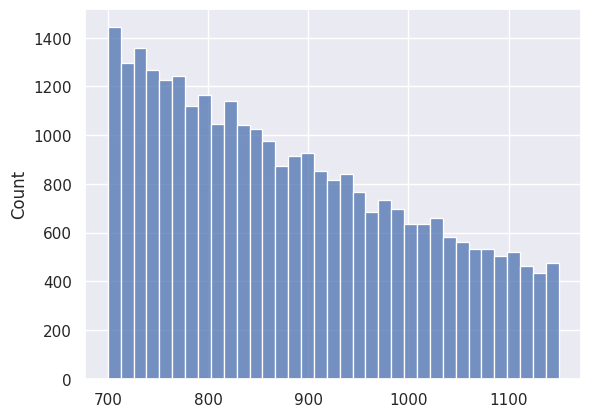

In [13]:
fig, ax = plt.subplots()

sns.histplot(lens, ax=ax)

fig.savefig(FIGS_PATH / "train_len.svg")

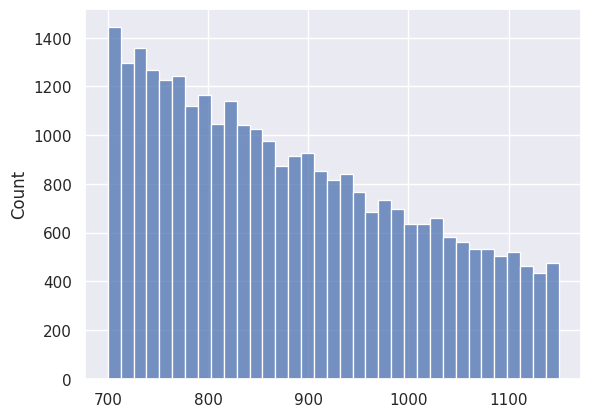

In [23]:
fig, ax = plt.subplots()

sns.histplot(lens, ax=ax)

fig.savefig(FIGS_PATH / "test_len.svg")

In [15]:
df_train[CAT_FEATURES].nunique()

small_group    202
dtype: int64

In [24]:
df_test[CAT_FEATURES].nunique()

small_group    202
dtype: int64

In [17]:
last_dt = (
    df_train
    .groupby("client_id")
    ["trans_date"]
    .max()
)

In [19]:
dts = (
    df_train
    [["client_id", "trans_date"]]
    .set_index("client_id")
    .pipe(lambda df: df.join(df.groupby(level=0).size().rename("weights")))
    .assign(weights=lambda df: 1 / df.weights / df.index.nunique())
)
dts

,trans_date,weights
client_id,,
33172,6,4.317789e-08
33172,6,4.317789e-08
33172,8,4.317789e-08
33172,9,4.317789e-08
33172,10,4.317789e-08
...,...,...
43300,727,3.711952e-08
43300,727,3.711952e-08
43300,727,3.711952e-08


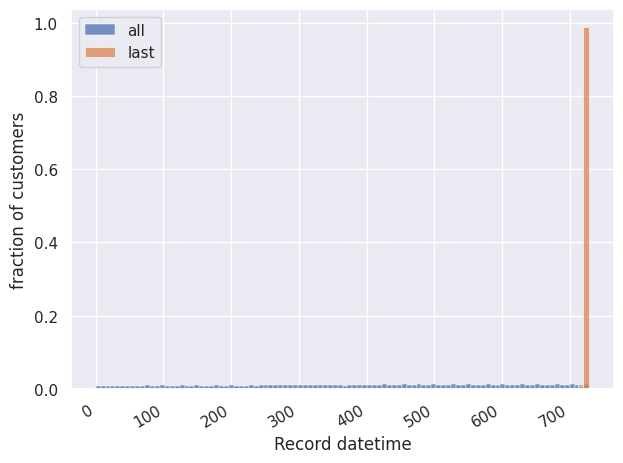

In [20]:
fig, ax = plt.subplots(layout="tight")

sns.histplot(
    dts,
    x="trans_date",
    weights="weights",
    bins=100,
    ax=ax,
    label="all",
)

sns.histplot(
    x=last_dt,
    weights=np.ones(len(last_dt)) / len(last_dt),
    bins=10,
    ax=ax,
    label="last",
)

ax.set_xlabel("Record datetime")
ax.set_ylabel("fraction of customers")
ax.legend()
fig.autofmt_xdate()

fig.savefig(FIGS_PATH / "rec_time_hist.svg")

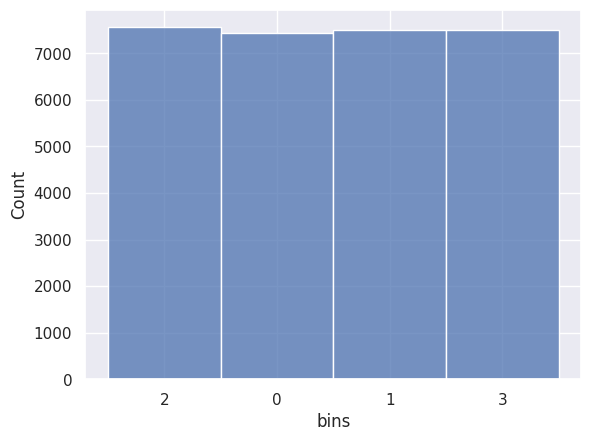

In [21]:
fig, ax = plt.subplots()

sns.histplot(target_train["bins"].astype(str), ax=ax)

fig.savefig(FIGS_PATH / "target.svg")